In [ ]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv, save_estimated_vec3_csv
from evaluation import plot_err_colored_by_weights, evaluate_estimated_vec3_autosign
from resample import find_stable_start_idx, cut_sample
from autotune import auto_setup_imu_frame, quasi_static_detector, suggest_gate_sigma
from autotune import choose_tau_from_quasi_static, choose_best_by_sigma_scale
from Tee import Tee

SIGMA_FLOOR: float = 1e-3
EPS: float = 1e-9

In [2]:
sample_1: str = "data01_21:08_oct_07_2025_5min"
sample_2: str = "data02_21:23_oct_07_2025_9min"
sample_3: str = "data03_21:41_oct_07_2025_13min"
sample_4: str = "data04_18:52_oct_08_2025_96min"

sample: str = sample_1

root: Path = Path.cwd().parent
run_dir: Path = root / "data" / sample

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, acc_path, grav_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

out_dir: Path = root / "output" / sample
out_dir.mkdir(parents=True, exist_ok=True)

out_log: Path = out_dir / "02_exp2_log.txt"

if out_log.is_file():
        out_log.unlink()

In [3]:
with Tee(out_log):
        t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

        q_ref_interp = load_ref(ori_path, t_new)
        q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

        idx_cut: int = find_stable_start_idx(dt, w_avg_gyro, q_ref_interp,
                                        sample_window=1000, threshold=0.5, sample_hz=100,
                                        consecutive=3, min_cut_second=10, max_cut_second=30)
        t_cut: int = idx_cut / 100

        a_src_interp = load_acc(acc_path, t_new)

        dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp = cut_sample(idx_cut,
                                                                [dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp])



[START] 2026-02-27 21:03:06.858

[INFO] Stabilization detected too early (< min_cut), applying min_cut=10s policy

[END] 2026-02-27 21:03:07.388




In [4]:
with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()
        g0: float = 9.80665
        a_src_interp, g_world_unit = auto_setup_imu_frame(q_ref_interp, w_avg_gyro, dt,
                                                                g0, a_src_interp)
        print("")

        quasi_static_mask, best_quasi_static = quasi_static_detector(w_avg_gyro, a_src_interp, dt, g0,
                                                                        w_thr=4, a_thr=4,
                                                                        min_duration_s=0.5, smooth_win=5)
        print("")

        gyro_gate_sigma, acc_gate_sigma = suggest_gate_sigma(w_avg_gyro, a_src_interp, g0,
                                                                p_gyro=90, p_acc=90, sigma_floor=SIGMA_FLOOR,
                                                                best_quasi_static=best_quasi_static)



[START] 2026-02-27 21:03:07.407

Detected accel unit in [m/s²]


Selected g_world_unit: [ 0  0 -1]

Best quasi static(start, end, length):  (2523, 3540, 1017)

Suggested gyro_sigma:  0.44791971689543864
Suggested acc_sigma:  2.908568806018301

[END] 2026-02-27 21:03:08.463




In [5]:
from typing import Any
def runner_exp2(*,
               K: float,
               acc_gate_sigma: float,
               gyro_gate_sigma = np.inf,
               mag_gate_sigma = np.inf,
               **kwargs: Any):
        q_est, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc(
                                                        q0, w_avg_gyro, dt,
                                                        K, g0, g_world_unit,
                                                        acc_gate_sigma, gyro_gate_sigma, a_src_interp)
        return q_est, (g_body_est, a_lin_est, weight_acc, weight_gyro)

In [6]:
## exp1: without any gating

with Tee(out_log):
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(dt=dt, runner_func=runner_exp2,      
                                                                     best_quasi_static=best_quasi_static,
                                                                     tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                                     runner_kwargs={"acc_gate_sigma": np.inf,
                                                                                    "gyro_gate_sigma": np.inf})
        print("")
        print("suggest tau: ", best_tau, ", K: ", K)
        print("")

        q_gyro_acc_1, extra = runner_exp2(K=K, acc_gate_sigma=np.inf, gyro_gate_sigma=np.inf)
        g_body_est_1, a_lin_est_1, weight_acc_1, weight_gyro_1 = extra

        print("[choosen value]")
        print("tau=", best_tau, "K=", K)
        print("sa=inf, sg=inf")
        print("")

        angle_err_gyro_acc_1: ScalarBatch = calc_angle_err(q_gyro_acc_1, q_ref_interp)
        print_err_status("Gyro+Acc", angle_err_gyro_acc_1)



[START] 2026-02-27 21:03:08.509

tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.0453472834175563
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.03706716993476759
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03127072144959298
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.030268340351771967
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.03065495906772654
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.031313599345832714
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.031135931826132664
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.029962505648007294

suggest tau:  3.0 , K:  0.003332926432292993

[choosen value]
tau= 3.0 K= 0.003332926432292993
sa=inf, sg=inf

Gyro+Acc angle error in rad — min/max/mean/p90
0.0028253656890090757 1.4041137225284805 0.3414149857047015 0.5148755033035524

Gyr

In [7]:
# exp 2-2: Gyro+Acc+Gating(Acc)

with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()

        print("[choosing tau, K]")
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(dt=dt, runner_func=runner_exp2,      
                                                                     best_quasi_static=best_quasi_static,
                                                                     tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                                     runner_kwargs={"acc_gate_sigma": acc_gate_sigma,
                                                                                    "gyro_gate_sigma": np.inf})
        print("")
        print("chosen tau: ", best_tau, ", K: ", K)
        print("")

        print("[choosing acc_gate_sigma]")
        best_acc = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                          K=K, sigma_base=acc_gate_sigma, q_ref=q_ref_interp,
                                          runner_func=runner_exp2,
                                          sigma_kw="acc_gate_sigma",
                                          fixed_kwargs={"gyro_gate_sigma": np.inf})
        print("")
        print(f"chosen sa={best_acc.scale}, ", f"acc_gate_sigma={best_acc.sigma:.7f}, ")
        print("")

        best_acc_scale, best_acc_sigma = best_acc.scale, best_acc.sigma
        angle_err_gyro_acc_2 = best_acc.angle_err
        g_body_est_2, a_lin_est_2, weight_acc_2, weight_gyro_2 = best_acc.extra

        print("[choosen value]")
        print("tau=", best_tau, ", K=", K)
        print(f"sa={best_acc_scale}, ", f"acc_gate_sigma={best_acc_sigma:.7f}, ", "sg=inf")
        print("")

        print_err_status("Gyro+Acc+Gating(Acc)", angle_err_gyro_acc_2)



[START] 2026-02-27 21:03:59.505

[choosing tau, K]
tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.0437275322370169
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.03660690253873771
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03234543260647222
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.03201273748875968
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.0326082798955483
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.03285388837167838
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.03225662424307239
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.030734069360916487

chosen tau:  3.0 , K:  0.003332926432292993

[choosing acc_gate_sigma]
scale=0.01 , acc_gate_sigma=0.0290857 , mean_err(rad)=0.3636687
scale=1 , acc_gate_sigma=2.9085688 , mean_err(rad)=0.3401973
scale=10 , acc_gate_sigma=29.08

In [15]:
# exp 2-3: Gyro+Acc+Gating(Gyro/Acc)

with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()

        print("[choosing tau, K]")
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(dt=dt, runner_func=runner_exp2,      
                                                                     best_quasi_static=best_quasi_static,
                                                                     tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                                     runner_kwargs={"acc_gate_sigma": acc_gate_sigma,
                                                                                    "gyro_gate_sigma": gyro_gate_sigma})
        print("")
        print("chosen tau: ", best_tau, ", K: ", K)
        print("")

        print("[choosing acc_gate_sigma]")
        best_acc = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                          K=K, sigma_base=acc_gate_sigma, q_ref=q_ref_interp,
                                          runner_func=runner_exp2,
                                          sigma_kw="acc_gate_sigma",
                                          fixed_kwargs={"gyro_gate_sigma": np.inf})
        print("")
        print(f"chosen sa={best_acc.scale}, ", f"acc_gate_sigma={best_acc.sigma:.7f}, ")
        print("")
        best_acc_scale, best_acc_sigma = best_acc.scale, best_acc.sigma
        
        print("[choosing gyro_gate_sigma]")
        best_gyro = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                          K=K, sigma_base=gyro_gate_sigma, q_ref=q_ref_interp,
                                          runner_func=runner_exp2,
                                          sigma_kw="gyro_gate_sigma",
                                          fixed_kwargs={"acc_gate_sigma": best_acc_sigma})
        print("")
        print(f"chosen sg={best_gyro.scale}, ", f"gyro_gate_sigma={best_gyro.sigma:.7f}, ")
        print("")
        best_gyro_scale, best_gyro_sigma = best_gyro.scale, best_gyro.sigma

        angle_err_gyro_acc_3 = best_gyro.angle_err
        g_body_est_3, a_lin_est_3, weight_acc_3, weight_gyro_3 = best_gyro.extra

        print("[choosen value]")
        print("tau=", best_tau, ", K=", K)
        print(f"sa={best_acc_scale}, ", f"acc_gate_sigma={best_acc_sigma:.7f}, ",
              f"sg={best_gyro_scale}, ", f"gyro_gate_sigma={best_gyro_sigma:.7f}")
        print("")

        print_err_status("Gyro+Acc+Gating(Gyro/Acc)", angle_err_gyro_acc_3)



[START] 2026-02-27 21:07:46.110

[choosing tau, K]
tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.03943992605456148
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.033983562129765534
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03155513160068821
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.03164593770576931
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.03185542227322495
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.031138085296789686
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.03003151214641173
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.028151859762228833

chosen tau:  3.0 , K:  0.003332926432292993

[choosing acc_gate_sigma]
scale=0.01 , acc_gate_sigma=0.0290857 , mean_err(rad)=0.3636687
scale=1 , acc_gate_sigma=2.9085688 , mean_err(rad)=0.3401973
scale=10 , acc_gate_sigma=2

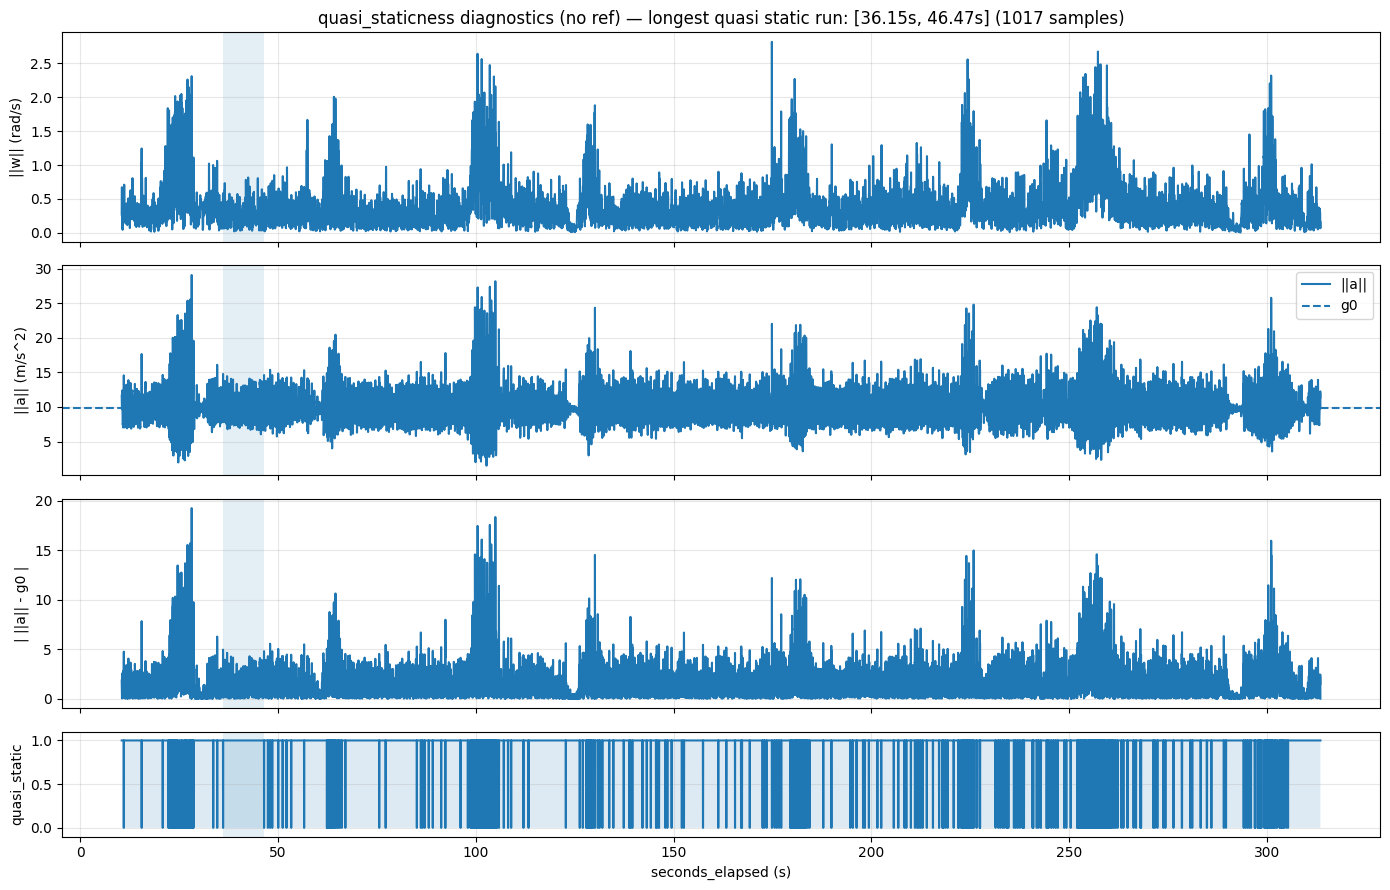

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quasi_static_diagnostics(
    t,
    w_avg_gyro,
    a_src,
    quasi_static_mask,
    g0=9.80665,
    quasi_static_run=None,          # (start, end, len) or None
    title="quasi_staticness diagnostics (no ref)"
):
    """
    Plots:
      1) gyro norm ||w||
      2) accel norm ||a|| and g0
      3) accel residual | ||a|| - g0 |
      4) quasi_static mask (0/1)

    Also highlights the longest quasi_static run if provided.
    """
    t = np.asarray(t).reshape(-1)
    w = np.asarray(w_avg_gyro)
    a = np.asarray(a_src)
    quasi_static = np.asarray(quasi_static_mask).astype(bool)

    wn = np.linalg.norm(w, axis=1)
    an = np.linalg.norm(a, axis=1)
    acc_resid = np.abs(an - g0)

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 9), height_ratios=[2, 2, 2, 1])

    # 1) gyro norm
    axs[0].plot(t, wn)
    axs[0].set_ylabel("||w|| (rad/s)")
    axs[0].grid(True, alpha=0.3)

    # 2) accel norm
    axs[1].plot(t, an, label="||a||")
    axs[1].axhline(g0, linestyle="--", label="g0")
    axs[1].set_ylabel("||a|| (m/s^2)")
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    # 3) accel residual
    axs[2].plot(t, acc_resid)
    axs[2].set_ylabel("| ||a|| - g0 |")
    axs[2].grid(True, alpha=0.3)

    # 4) quasi_static mask
    axs[3].plot(t, quasi_static.astype(int))
    axs[3].set_ylabel("quasi_static")
    axs[3].set_ylim(-0.1, 1.1)
    axs[3].grid(True, alpha=0.3)
    axs[3].set_xlabel("seconds_elapsed (s)")

    # shade all quasi_static regions lightly
    # (simple approach: shade where quasi_static==True using fill_between)
    axs[3].fill_between(t, 0, 1, where=quasi_static, alpha=0.15, step="pre")

    # highlight longest run if provided
    if quasi_static_run is not None:
        s, e, _ = quasi_static_run
        t0, t1 = t[s], t[e-1]
        for ax in axs:
            ax.axvspan(t0, t1, alpha=0.12)
        axs[0].set_title(f"{title} — longest quasi static run: [{t0:.2f}s, {t1:.2f}s] ({e-s} samples)")
    else:
        axs[0].set_title(f"{title} — no quasi static run found")

    plt.tight_layout()
    plt.show()

plot_quasi_static_diagnostics(t_new, w_avg_gyro, a_src_interp, quasi_static_mask, g0=9.80665, quasi_static_run=best_quasi_static)

In [17]:
out_path_1: Path = out_dir / "02_exp2-1_angle_err_gyro_acc.csv"
out_path_2: Path = out_dir / "02_exp2-2_angle_err_gyro_acc.csv"
out_path_3: Path = out_dir / "02_exp2-3_angle_err_gyro_acc.csv"
save_err_csv(out_path_1, t_new, angle_err_gyro_acc_1)
save_err_csv(out_path_2, t_new, angle_err_gyro_acc_2)
save_err_csv(out_path_3, t_new, angle_err_gyro_acc_3)

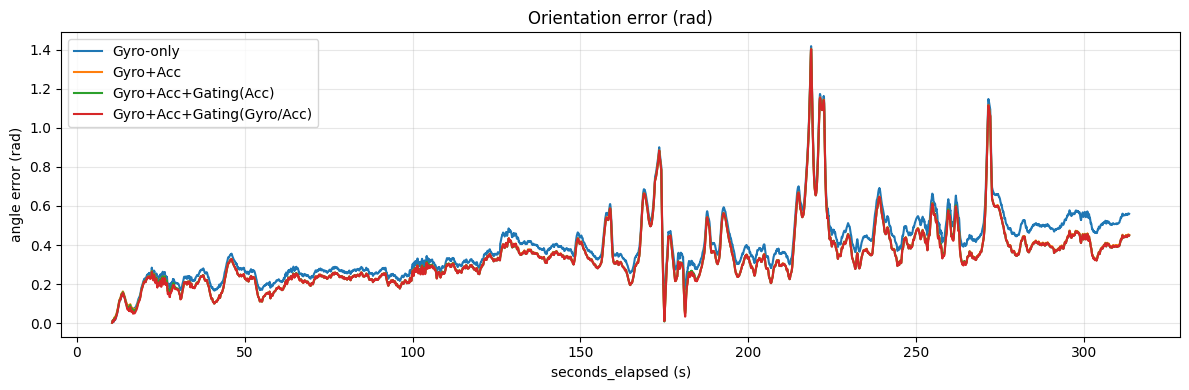

In [18]:
out_gyro_path = out_dir / "01_exp1-2_angle_err_gyro.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro+Acc", out_path_1),
        ("Gyro+Acc+Gating(Acc)", out_path_2),
        ("Gyro+Acc+Gating(Gyro/Acc)", out_path_3)],
                  out_dir / "02_exp2")

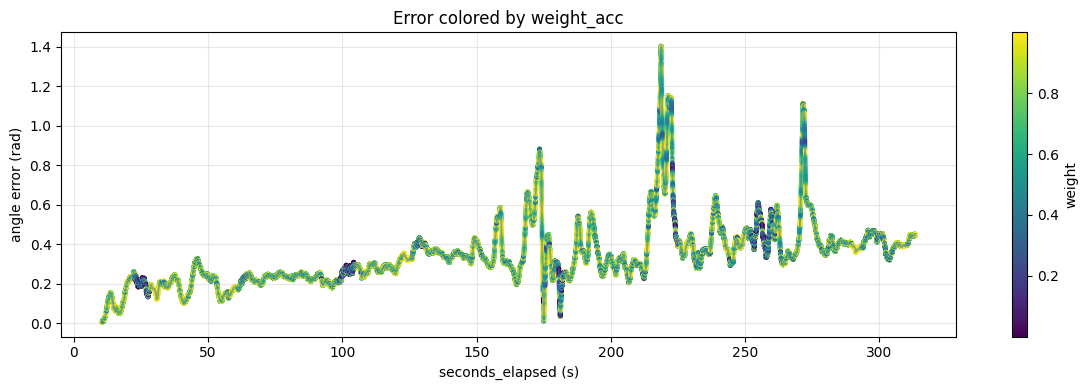

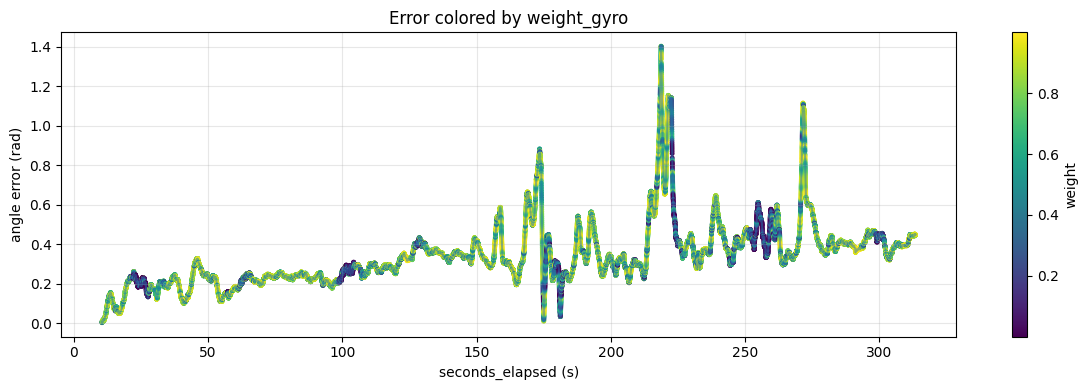

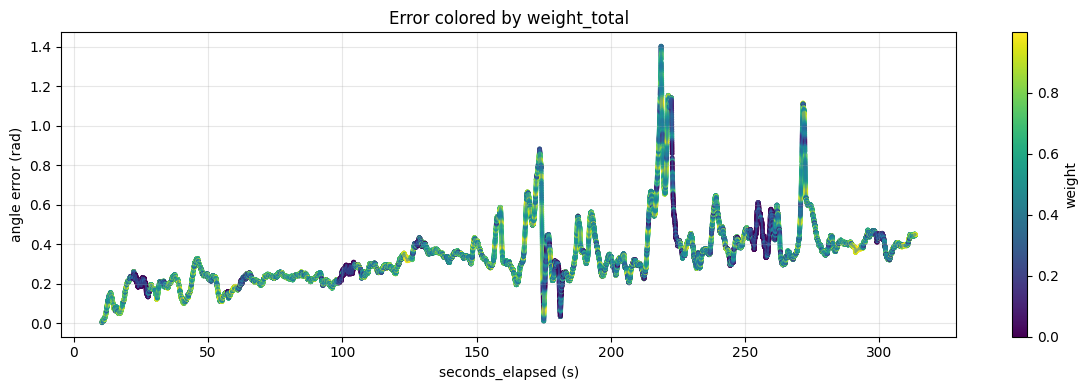

In [19]:
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3, "weight_acc")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_gyro_3, "weight_gyro")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3 * weight_gyro_3, "weight_total")

In [13]:
#est_dir: Path = root / "estimate"
#est_dir.mkdir(parents=True, exist_ok=True)

#print("Gravity:")
#g_ref_interp = load_grav_ref(grav_path, t_new)
#g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
#print("")

#print("Linear Acc:")
#a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
#a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
#print("")

#save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
#save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

#print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

In [14]:
#import numpy as np

#def unit(v):
#    n = np.linalg.norm(v, axis=1, keepdims=True)
#    return v / np.maximum(n, 1e-12)

#def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
#    ge = unit(g_est)
#    gr = unit(g_ref)
#    c = np.sum(ge * gr, axis=1)
#    c = np.clip(c, -1.0, 1.0)
#    ang = np.arccos(c)  # rad
#    print("gravity dir angle err (rad): min/max/mean",
#          float(ang.min()), float(ang.max()), float(ang.mean()))
#    print("gravity dir angle err (deg): min/max/mean",
#          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
#    return ang

#def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
#    a_norm = np.linalg.norm(a_src, axis=1)
#    mask = np.abs(a_norm - g0) < thr

#    au = unit(a_src)
#    gu = unit(g_est)
#    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

#    d = dot[mask]
#    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
#    print("dot(a_unit, g_unit) on stationary: mean/min/max",
#          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
#    return dot, mask

#gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
#print("=============")
#accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)
#print("=============")